In [1]:
import os
import sys
import numpy as np
from numpy.random import RandomState, SeedSequence, MT19937
import matplotlib.pyplot as plt

powerfactory_path = r'C:\Program Files\DIgSILENT\PowerFactory 2020 SP4\Python\3.8'
if powerfactory_path not in sys.path:
    sys.path.append(powerfactory_path)
import powerfactory as pf

In [2]:
app = pf.GetApplication()
if app is None:
    raise Exception('Cannot get PowerFactory application')
else:
    print('Successfully obtained PowerFactory application.')

Successfully obtained PowerFactory application.


In [3]:
project_name = '\\Terna_Inerzia\\WSCC'
err = app.ActivateProject(project_name)
if err:
    raise Exception(f'Cannot activate project {project_name}')
print(f'Successfully activated project {project_name}.')

Successfully activated project \Terna_Inerzia\WSCC.


In [4]:
project = app.GetActiveProject()
if project is None:
    raise Exception('Cannot get active project')
print('Successfully obtained active project.')

Successfully obtained active project.


In [5]:
project_folders = {}
for folder_name in ('study',):
    project_folders[folder_name] = app.GetProjectFolder(folder_name)
    if project_folders[folder_name] is None:
        raise Exception(f'No folder "{folder_name}" present')
    print(f'Successfully obtained folder "{folder_name}".')

Successfully obtained folder "study".


## Load flow analysis

In [6]:
study_case_name = '01- Load Flow'
if '.IntCase' not in study_case_name and False:
    study_case_name += '.IntCase'
study_case = project_folders['study'].GetContents(study_case_name)[0]
err = study_case.Activate() # don't know why this returns 1
# if err:
#     raise Exception(f'Cannot activate study case {study_case_name}')
print(f'Successfully activated study case {study_case_name}.')

Successfully activated study case 01- Load Flow.


In [7]:
load_flow = app.GetFromStudyCase('ComLdf')
err = load_flow.Execute()
if err:
    raise Exception(f'Cannot run load flow')
print(f'Successfully run load flow.')

Successfully run load flow.


In [8]:
for bus in app.GetCalcRelevantObjects('*.ElmTerm'):
    voltage = bus.GetAttribute('m:u')
    print(f'{bus.loc_name}: voltage = {voltage:.3f} pu')
    
for load in app.GetCalcRelevantObjects('*.ElmLod'):
    P = load.GetAttribute('m:Psum:bus1')
    Q = load.GetAttribute('m:Qsum:bus1')
    print(f'{load.loc_name}: P = {P:6.2f} MW, Q = {Q:5.2f} MVAR')

Bus 1: voltage = 1.040 pu
Bus 2: voltage = 1.025 pu
Bus 3: voltage = 1.025 pu
Bus 4: voltage = 1.026 pu
Bus 5: voltage = 0.996 pu
Bus 6: voltage = 1.013 pu
Bus 7: voltage = 1.026 pu
Bus 8: voltage = 1.016 pu
Bus 9: voltage = 1.032 pu
Load A: P = 125.00 MW, Q = 50.00 MVAR
Load B: P =  90.00 MW, Q = 30.00 MVAR
Load C: P = 100.00 MW, Q = 35.00 MVAR


## Transient stability analysis

In [9]:
def get_simulation_variables(res, var_name, elements=None, elements_name=None, app=None):
    full_output = False
    if elements is None:
        if elements_name is None:
            raise Exception('You must provide one of "elements" or "elements_name"')
        if app is None:
            raise Exception('You must provide "app" if "elements_name" is passed')
        full_output = True
        elements = app.GetCalcRelevantObjects(elements_name)
    n_samples = res.GetNumberOfRows()
    variables = np.zeros((n_samples, len(elements)))
    for i,element in enumerate(elements):
        col = res.FindColumn(element, var_name)
        if col < 0:
            raise Exception(f'Variable {var_name} is not available.')
        variables[:,i] = np.array([res.GetValue(j, col)[1] for j in range(n_samples)])
    if full_output:
        return np.squeeze(variables), elements
    return np.squeeze(variables)

get_simulation_time = lambda res: np.array([res.GetValue(i, -1)[1] for i in range(res.GetNumberOfRows())])

In [10]:
def OU(dt, alpha, mu, c, N, random_state = None):
    coeff = np.array([alpha * mu * dt, 1 / (1 + alpha * dt)])
    if random_state is not None:
        rnd = c * np.sqrt(dt) * random_state.normal(size=N)
    else:
        rnd = c * np.sqrt(dt) * np.random.normal(size=N)
    ou = np.zeros(N)
    ou[0] = mu
    for i in range(N-1):
        ou[i+1] = (ou[i] + coeff[0] + rnd[i]) * coeff[1]
    return ou

In [11]:
study_case_name = '09- Transient Stability'
if '.IntCase' not in study_case_name and False:
    study_case_name += '.IntCase'
study_case = project_folders['study'].GetContents(study_case_name)[0]
err = study_case.Activate() # don't know why this returns 1
# if err:
#     raise Exception(f'Cannot activate study case {study_case_name}')
print(f'Successfully activated study case {study_case_name}.')

Successfully activated study case 09- Transient Stability.


Objects that will be used in the following:

In [12]:
generators = app.GetCalcRelevantObjects('*.ElmSym')
loads = app.GetCalcRelevantObjects('*.ElmLod')
buses = app.GetCalcRelevantObjects('*.ElmTerm')

Find the load that should be stochastic:

In [13]:
stochastic_load_name = 'Load A'
found = False
for load in loads:
    if load.loc_name == stochastic_load_name:
        stochastic_load = load
        found = True
        print(f'Found load named {stochastic_load_name}.')
        break
if not found:
    raise Exception(f'Cannot find load named {stochastic_load_name}')

composite_model_name = 'Stochastic Load'
found = False
for composite_model in app.GetCalcRelevantObjects('*.ElmComp'):
    if composite_model.loc_name == composite_model_name:
        stochastic_load_model = composite_model
        found = True
        print(f'Found composite model named {composite_model_name}.')
        break
if not found:
    raise Exception(f'Cannot find composite model named {composite_model_name}')

for slot,net_element in zip(stochastic_load_model.pblk, stochastic_load_model.pelm):
    if slot.loc_name == 'load slot':
        net_element = stochastic_load
        print(f'Set {stochastic_load_name} as stochastic load.')

Found load named Load A.
Found composite model named Stochastic Load.
Set Load A as stochastic load.


Find the path of the file containing the dynamics of the stochastic load

In [14]:
measurement_file_obj = app.GetCalcRelevantObjects('*.ElmFile')[0]
stochastic_load_filename = measurement_file_obj.f_name
print(f'The stochastic load file is {stochastic_load_filename}.')

The stochastic load file is C:\Users\Terna_Inerzia\Desktop\PowerFactory\Stochastic_Load.txt.


Write the file with the stochastic load

In [15]:
dt = 0.1e-3
tend = 1
N = int(tend / dt) + 1
seed = 10
alpha = 1
P0 = stochastic_load.plini
Q0 = stochastic_load.qlini
c = 30
rs = RandomState(MT19937(SeedSequence(seed)))
tPQ = np.zeros((N,3))
tPQ[:,0] = np.linspace(0, tend, N)
tPQ[:,1] = OU(dt, alpha, P0, c, N, rs)
tPQ[:,2] = Q0
with open(stochastic_load_filename, 'w') as fid:
    fid.write('2\n\n')
    for row in tPQ:
        fid.write(f'{row[0]:.6f}\t{row[1]:.2f}\t{row[2]:.2f}\n\n')

In [16]:
monitored_variables = {
    '*.ElmSym': ['s:xspeed'],
    '*.ElmLod': ['m:Psum:bus1', 'm:Qsum:bus1'],
    '*.ElmTerm': ['m:u', 'm:ur', 'm:ui', 'm:u1', 'm:u1r', 'm:u1i', 'm:Pflow', 'm:Qflow', 'm:Pout', 'm:Qout']
}
# the results of the transient simulation will be stored in this variable
res = app.GetFromStudyCase('*.ElmRes')
for elements,var_names in monitored_variables.items():
    for element in app.GetCalcRelevantObjects(elements):
        for var_name in var_names:
            res.AddVariable(element, var_name)

In [17]:
inc = app.GetFromStudyCase('ComInc')
inc.iopt_sim = 'rms'
inc.tstart = 0
inc.dtgrd = dt
err = inc.Execute()
if err:
    raise Exception('Cannot compute initial condition')
print('Successfully computed initial condition.')

Successfully computed initial condition.


In [18]:
sim = app.GetFromStudyCase('ComSim')
sim.tstop = tend
err = sim.Execute()
if err:
    raise Exception('Cannot run transient simulation')
print('Successfully run transient simulation.')
# app.ResLoadData(res)
res.Load()

Successfully run transient simulation.


Get the data:

In [19]:
sys.stdout.write('.')
sys.stdout.flush()
time = get_simulation_time(res)

sys.stdout.write('.')
sys.stdout.flush()
speed = get_simulation_variables(res, 's:xspeed', elements=generators)

sys.stdout.write('.')
sys.stdout.flush()
P = get_simulation_variables(res, 'm:Psum:bus1', elements=loads)

sys.stdout.write('.')
sys.stdout.flush()
Q = get_simulation_variables(res, 'm:Qsum:bus1', elements=loads)

sys.stdout.write('.')
sys.stdout.flush()
V = get_simulation_variables(res, 'm:u', elements=buses)

sys.stdout.write('.')
sys.stdout.flush()
Vr = get_simulation_variables(res, 'm:ur', elements=buses)

sys.stdout.write('.')
sys.stdout.flush()
Vi = get_simulation_variables(res, 'm:ui', elements=buses)

# sys.stdout.write('.')
# sys.stdout.flush()
# Pflow = get_simulation_variables(res, 'm:Pflow', elements=buses)

# sys.stdout.write('.')
# sys.stdout.flush()
# Qflow = get_simulation_variables(res, 'm:Qflow', elements=buses)

# sys.stdout.write('.')
# sys.stdout.flush()
# Pout = get_simulation_variables(res, 'm:Pout', elements=buses)

# sys.stdout.write('.')
# sys.stdout.flush()
# Qout = get_simulation_variables(res, 'm:Qout', elements=buses)

.......

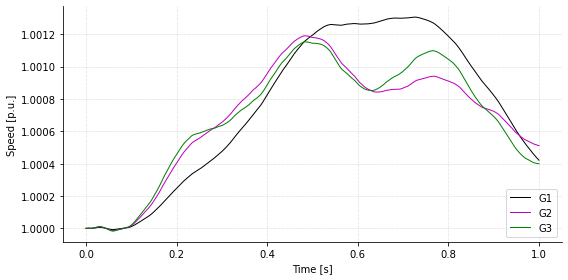

In [20]:
col = 'kmg'
fig,ax = plt.subplots(1, 1, figsize=(8,4))
for i,generator in enumerate(generators):
    ax.plot(time, speed[:,i], col[i], lw=1, label=generator.loc_name)
ax.legend(loc='lower right')
for side in 'right','top':
    ax.spines[side].set_visible(False)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Speed [p.u.]')
ax.grid(which='major', axis='both', lw=0.5, ls=':')
fig.tight_layout()

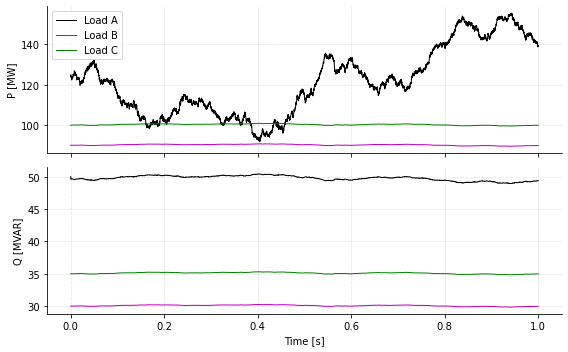

In [21]:
col = 'kmg'
fig,ax = plt.subplots(2, 1, figsize=(8,5), sharex=True)
for i,load in enumerate(loads):
    ax[0].plot(time, P[:,i], col[i], lw=1, label=load.loc_name)
    ax[1].plot(time, Q[:,i], col[i], lw=1, label=load.loc_name)
ax[0].legend(loc='upper left')
for a in ax:
    a.grid(which='major', axis='both', lw=0.5, ls=':')
    for side in 'right','top':
        a.spines[side].set_visible(False)
ax[1].set_xlabel('Time [s]')
ax[0].set_ylabel('P [MW]')
ax[1].set_ylabel('Q [MVAR]')
fig.tight_layout()

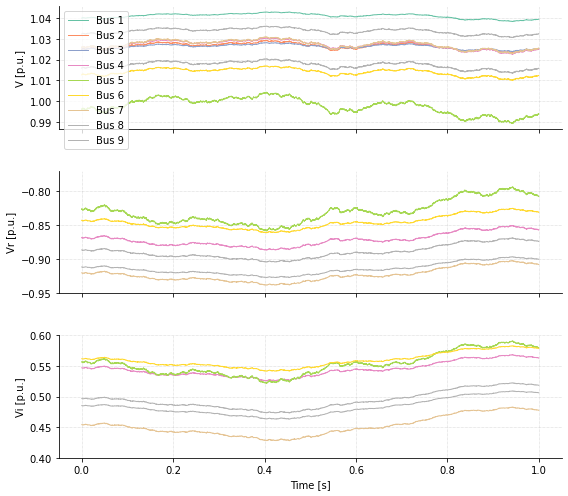

In [22]:
cmap = plt.get_cmap('Set2', len(buses))
fig,ax = plt.subplots(3, 1, figsize=(8,7), sharex=True)
for i,load in enumerate(buses):
    ax[0].plot(time, V[:,i], color=cmap(i), lw=1, label=load.loc_name)
    ax[1].plot(time, Vr[:,i], color=cmap(i), lw=1, label=load.loc_name)
    ax[2].plot(time, Vi[:,i], color=cmap(i), lw=1, label=load.loc_name)
ax[0].legend(loc='upper left')
for a in ax:
    a.grid(which='major', axis='both', lw=0.5, ls=':')
    for side in 'right','top':
        a.spines[side].set_visible(False)
ax[-1].set_xlabel('Time [s]')
ax[0].set_ylabel('V [p.u.]')
ax[1].set_ylabel('Vr [p.u.]')
ax[2].set_ylabel('Vi [p.u.]')
ax[1].set_ylim([-0.95,-0.77])
ax[2].set_ylim([0.4,0.6])
fig.tight_layout()